In [2]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

import timm

assert timm.__version__ == "0.3.2" # 버전 체크 - timm 0.3.2 버전 확인
from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

# 커스텀 유틸리티 모듈들 임포트
import util.lr_decay as lrd  # 학습률 스케줄링
import util.misc as misc  # 기타 유틸리티 함수들
from util.datasets import build_dataset  # 데이터셋 생성
from util.pos_embed import interpolate_pos_embed  # 위치 임베딩 보간
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import models_vit  # Vision Transformer 모델

from engine_finetune import train_one_epoch, evaluate  # 훈련 및 평가 엔진


In [3]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, transforms
import PIL
def build_transform(is_train):
    input_size = 224
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD
    # train transform

    # eval transform
    t = []
    if input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


def build_dataset(is_train):
    transform = build_transform(is_train)
    data_path = "/data/docparser_mh/temp/data/ImageNet"
    root = os.path.join(data_path, 'train' if is_train else 'val')
    dataset = datasets.ImageFolder(root, transform=transform)

    print(dataset)

    return dataset

In [4]:
device = torch.device("cuda")
# 재현성을 위한 시드 고정
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True  # CuDNN 성능 최적화

# 훈련 및 검증 데이터셋 구성
# dataset_train = build_dataset(is_train=True, args=args)
dataset_val = build_dataset(is_train=False)

# 분산 훈련을 위한 데이터 샘플러 설정

sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# 텐서보드 로거 설정
log_writer = None

# 데이터 로더 생성
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=4,
    num_workers=0,
    pin_memory=False,
    drop_last=False  # 검증 시에는 모든 샘플 사용
)

# Vision Transformer 모델 생성
model = models_vit.__dict__["vit_base_patch16"](
    num_classes=1000,
    drop_path_rate=0.1,
    global_pool=True,
    mask_ratio=0.4,
)

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /data/docparser_mh/temp/data/ImageNet/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [5]:
FineTune = "/data/docparser_mh/temp/mae_temp/output_dir/checkpoint-1.pth"

checkpoint = torch.load(FineTune, map_location='cpu', weights_only=False)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()


for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"사전 훈련 체크포인트에서 키 {k} 제거")
        del checkpoint_model[k]

# 위치 임베딩 보간 (입력 크기가 다를 수 있음)
interpolate_pos_embed(model, checkpoint_model)

# 사전 훈련된 모델 로드
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

# Energy-based masking 관련 새로운 파라미터들 허용
expected_missing_keys = {'head.weight', 'head.bias'}
energy_masking_keys = {
    'register_token', 'energy_threshold', 
    'state_vectors.weight', 'state_vectors.bias',
    'energy_func_td.weight', 'energy_func_td.bias',
    'energy_func_bu.weight', 'energy_func_bu.bias', 
    'energy_func_lr.weight', 'energy_func_lr.bias',
    'energy_func_rl.weight', 'energy_func_rl.bias'
}

# if args.global_pool:
#     expected_missing_keys.update({'fc_norm.weight', 'fc_norm.bias'})
    
# Energy-based masking 파라미터들도 허용
expected_missing_keys.update(energy_masking_keys)

# 실제 missing keys가 예상된 범위 내에 있는지 확인
actual_missing = set(msg.missing_keys)
if not actual_missing.issubset(expected_missing_keys):
    unexpected_missing = actual_missing - expected_missing_keys
    print(f"Warning: Unexpected missing keys: {unexpected_missing}")
    # assert False, f"Unexpected missing keys: {unexpected_missing}"

# 분류 레이어 수동 초기화
trunc_normal_(model.head.weight, std=2e-5)


model.to(device)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['sos', 'state_vectors.weight', 'state_vectors.bias'])


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x CustomBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=768, out_features=1000, bias=True)
  (fc_norm): LayerN

In [9]:
import torch.nn.functional as F

for data_iter_step, (samples, targets) in enumerate(data_loader_val):
    samples = samples.to(device)
    targets = targets.to(device)

    x = samples
    B = x.shape[0]
    x_feat = model.patch_embed(x) # (4, 196, 768)
    x_feat = x_feat + model.pos_embed[:, 1:, :]
    q, keep_idx, rec_loss, cos = model.energy_based_masking(x_feat)

    H, W = model.img_size
    patch_H, patch_W = H // model.patch_size, W // model.patch_size
    B, L = keep_idx.shape

    mask = torch.zeros((B, patch_H, patch_W))
    mask = mask.reshape(B, -1)
    # mask[]
    keep_idx = keep_idx.cpu()
    
    # print(keep_idx.shape)
    # mask[keep_idx] = 1
    for i in range(len(mask)):
        mask[i][keep_idx[i]] = 1
    mask = mask.reshape(B, patch_H, patch_W)
    print(mask.shape)
    print(B, H, W)
    mask = mask.unsqueeze(1)

    mask = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
    mask = mask.squeeze()
    print(mask.shape)
    break

torch.Size([4, 14, 14])
4 224 224
torch.Size([4, 224, 224])


In [10]:
# mask = mask > 0.5

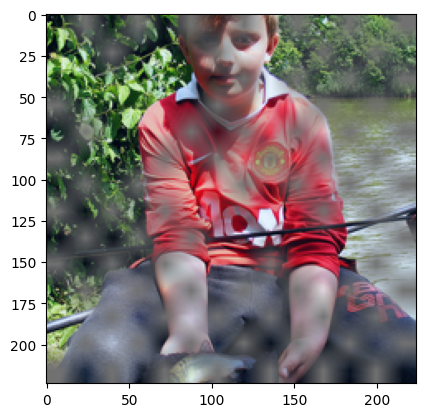

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


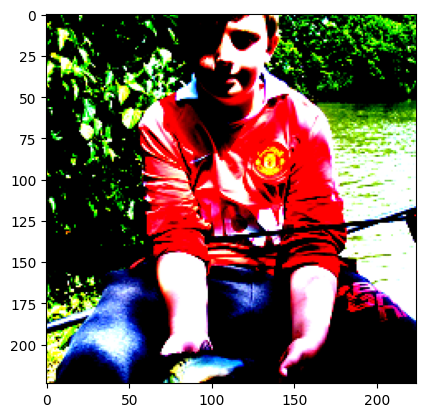

In [11]:
from matplotlib import pyplot as plt
idx = 2




image = samples[idx].cpu() * mask[idx]
image -= image.min()
image /= image.max()
plt.imshow(image.permute(1,2,0))
plt.show()
plt.imshow(samples[idx].cpu().permute(1,2,0))
plt.show()

In [ ]:
A = [[1, 0],[0,1]]
B = [[1,1,0,0], [1,1,0,0], [0,0,1,1], [0,0,1,1]]

In [9]:
import torch.nn.functional as F

a = torch.randn(4, 196, 768)
b = torch.randn(4, 196, 768)
F.l1_loss(a, b, reduction='none')

tensor([[[0.2699, 1.3402, 1.0269,  ..., 0.0426, 0.0893, 0.6687],
         [1.2109, 0.2164, 0.8968,  ..., 1.5741, 1.9954, 0.6515],
         [1.7235, 1.4302, 0.6770,  ..., 1.1468, 2.0913, 2.0341],
         ...,
         [0.1510, 0.6387, 2.2983,  ..., 1.5714, 1.5480, 1.4327],
         [2.1775, 1.6534, 0.0746,  ..., 2.5616, 1.2418, 2.2146],
         [0.0682, 2.4703, 0.0407,  ..., 0.0681, 0.1130, 0.1787]],

        [[0.2188, 0.0343, 1.6898,  ..., 0.1314, 2.7261, 0.6091],
         [1.0645, 1.8213, 2.5071,  ..., 0.8460, 0.9192, 0.4178],
         [0.7074, 1.2939, 1.4730,  ..., 2.1712, 1.6366, 0.2142],
         ...,
         [0.7711, 1.3623, 2.4545,  ..., 0.5332, 1.1099, 0.3683],
         [0.1081, 0.1549, 3.6466,  ..., 3.1621, 0.4593, 1.1214],
         [1.3534, 0.8537, 0.1364,  ..., 0.1921, 2.0612, 1.8368]],

        [[0.4530, 0.6946, 0.8186,  ..., 0.9927, 1.4564, 1.4144],
         [0.8929, 0.0183, 2.7759,  ..., 0.1039, 0.3666, 1.6221],
         [0.5216, 0.6234, 1.2890,  ..., 1.3861, 0.5131, 0.